In [131]:
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import dataset
from dataset import *

In [132]:
PERCENTILE = 5  # drop values in this percentile

In [133]:
def load(path: str):
    with open(path) as f:
        data = json.load(f)
    return data

In [134]:
def plot_histogram(dataset: dict[str, Dataset], key: str, title: str = None, time_unit: str = "ms", num_bins: int = 100):
    total = None
    bmin = float('inf')
    bmax = float('-inf')
    for label, ds in dataset.items():
        if key in ds.data:
            bmin = min(bmin, ds.data[key][0])
            bmax = max(bmax, ds.data[key][-1])

    match time_unit:
        case "ms":
            bmin /= 1_000_000
            bmax /= 1_000_000
        case "us":
            bmin /= 1_000
            bmax /= 1_000
    
    #bmin -= bmin % num_bins
    #bmax += num_bins - (bmax % num_bins)

    bstep = (bmax - bmin) / num_bins
    bins = np.arange(bmin, bmax, bstep)
    if title is None:
        title = key_to_string(key)

    plt.figure(figsize=(8, 5))
    ax = plt.subplot()
    for label, ds in dataset.items():
        if key in ds.data:
            match time_unit:
                case "ms":
                    data = ds.data[key] / 1_000_000
                    mean = ds.mean[key] / 1_000_000
                case "us":
                    data = ds.data[key] / 1_000
                    mean = ds.mean[key] / 1_000
                case "ns":
                    data = ds.data[key]
                    mean = ds.mean[key]
            _, _, p = ax.hist(data, label=f"{label}", histtype='step', cumulative=False, bins=bins, linewidth=2)
            (r, g, b, _) = p[0].get_facecolor()
            #ax.axvline(mean, label=f"{label} mean", linestyle='--', linewidth=2)
            ax.axvline(mean, label=f"mean={mean:.4f} {time_unit}", color=(r, g, b), linestyle=':', linewidth=2)
            if total is None:
                total = len(data)
            
    plt.legend()
    #plt.xticks(list(plt.xticks()[0]))
    plt.xlabel(f"Time ({time_unit})")
    plt.ylabel(f"Frequency (total={total})")
    plt.grid(visible=True)
    plt.title(title)
    #plt.xlim(left=bmin - np.fmod(bmin, bstep))
    #plt.xlim(right=bmax + bstep - np.fmod(bmin, bstep))
    #plt.ylim(0, 5)
    plt.savefig(f"./plots/svg/{title.replace(':', '-')}.svg", format="svg")
    plt.savefig(f"./plots//png/{title.replace(':', '-')}.png", format="png")
    plt.close()

In [135]:
client_tls = Dataset(load("data/client-benchmarks.json"))
client_tls_ra = Dataset(load("data/client-benchmarks-ra.json"))
client_no_ech = {
    "TLS": client_tls,
    "TLS with RA": client_tls_ra,
}
server_tls = Dataset(load("data/server-benchmarks.json"), False)
server_tls_ra = Dataset(load("data/server-benchmarks-ra.json"), False)
server_no_ech = {
    "TLS": server_tls,
    "TLS with RA": server_tls_ra,
}
client_ech = {
    "TLS with ECH": Dataset(load("data/client-benchmarks-ech.json")),
    "TLS with RA,ECH": Dataset(load("data/client-benchmarks-ra-ech.json")),
}
server_ech = {
    "TLS with ECH": Dataset(load("data/server-benchmarks-ech.json"), False),
    "TLS with RA,ECH": Dataset(load("data/server-benchmarks-ra-ech.json"), False),
}

In [136]:
for ds in client_no_ech.values():
    ds.truncate(PERCENTILE)
for ds in server_no_ech.values():
    ds.truncate(PERCENTILE)
for ds in client_ech.values():
    ds.truncate(PERCENTILE)
for ds in server_ech.values():
    ds.truncate(PERCENTILE)

In [137]:
# Handshake
plot_histogram(client_no_ech, "client_handshake", f"{key_to_string('client_handshake')} (no ECH)")
plot_histogram(client_ech, "client_handshake", f"{key_to_string('client_handshake')} (with ECH)")

# ClientHello
plot_histogram(client_no_ech, "client_hello", f"{key_to_string('client_hello')} (no ECH)")
plot_histogram(client_ech, "client_hello", f"{key_to_string('client_hello')} (with ECH)")

# ClientHello Extensions
plot_histogram(client_no_ech, "client_extensions", f"{key_to_string('client_extensions')} (no ECH)")
plot_histogram(client_ech, "client_extensions", f"{key_to_string('client_extensions')} (with ECH)")

# Client Certificate Verify
plot_histogram(client_no_ech, "client_certificate_verify")

# Client Certificate Verify: AttReq
plot_histogram(client_no_ech, "client_certificate_verify_att_request")

# Client Certificate Verify: AttReq Challenge Generation
plot_histogram(client_no_ech, "client_certificate_verify_att_request_challenge_generation")

In [138]:
# Handshake
plot_histogram(server_no_ech, "server_handshake", f"{key_to_string('server_handshake')} (no ECH)")
plot_histogram(server_ech, "server_handshake", f"{key_to_string('server_handshake')} (with ECH)")

# ServerHello
plot_histogram(server_no_ech, "server_hello", f"{key_to_string('server_hello')} (no ECH)")
plot_histogram(server_ech, "server_hello", f"{key_to_string('server_hello')} (with ECH)")

# Server EncryptedExtensions
plot_histogram(server_no_ech, "server_extensions", f"{key_to_string('server_extensions')} (no ECH)")
plot_histogram(server_ech, "server_extensions", f"{key_to_string('server_extensions')} (with ECH)")

# Server: AttReq Generation 
plot_histogram(server_no_ech, "server_att_request_generation")

# Server: AttReq Challenge Generation
plot_histogram(server_no_ech, "server_att_request_challenge_generation")

In [139]:
def plot_client_bar(datasets: dict[str, Dataset], title: str, median_or_average: bool = True):
    x = datasets.keys()

    plt.figure(figsize=(7,20))
    
    # ClientHello msg
    client_hello = np.zeros(len(datasets))
    for key in CLIENT_KEYS[0:3]:
        if median_or_average:
            y = [ds.mean[key] if key in ds.mean else 0 for ds in datasets.values()]
        else:
            y = [ds.mean[key] if key in ds.mean else 0 for ds in datasets.values()]
        # The keys are ordered so we can deduct the ones from before to get an overall time slice
        y = np.array(y) - client_hello
        
        plt.bar(x, y, bottom=client_hello, label=key)
        client_hello += y
    
    # Certificate Verify msg
    cert_verify = np.zeros(len(datasets))
    for key in CLIENT_KEYS[3:6]:
        if median_or_average:
            y = [ds.mean[key] if key in ds.mean else 0 for ds in datasets.values()]
        else:
            y = [ds.mean[key] if key in ds.mean else 0 for ds in datasets.values()]
        # The keys are ordered so we can deduct the ones from before to get an overall time slice
        y = np.array(y) - cert_verify
        
        plt.bar(x, y, bottom=client_hello + cert_verify, label=key)
        cert_verify += y
    
    # Handshake overall
    if median_or_average:
        y = [ds.mean[CLIENT_KEYS[6]] if CLIENT_KEYS[6] in ds.mean else 0 for ds in datasets.values()]
    else:
        y = [ds.mean[CLIENT_KEYS[6]] if CLIENT_KEYS[6] in ds.mean else 0 for ds in datasets.values()]
    # The keys are ordered so we can deduct the ones from before to get an overall time slice
    y = np.array(y) - (client_hello + cert_verify)
    plt.bar(x, y, bottom=client_hello + cert_verify, label=CLIENT_KEYS[6])

    plt.legend()
    plt.xlabel("Connection Type")
    plt.ylabel("mean Time (ns)" if median_or_average else "Average Time (ns)")
    plt.title(title)
    plt.grid(visible=True)
    plt.show()

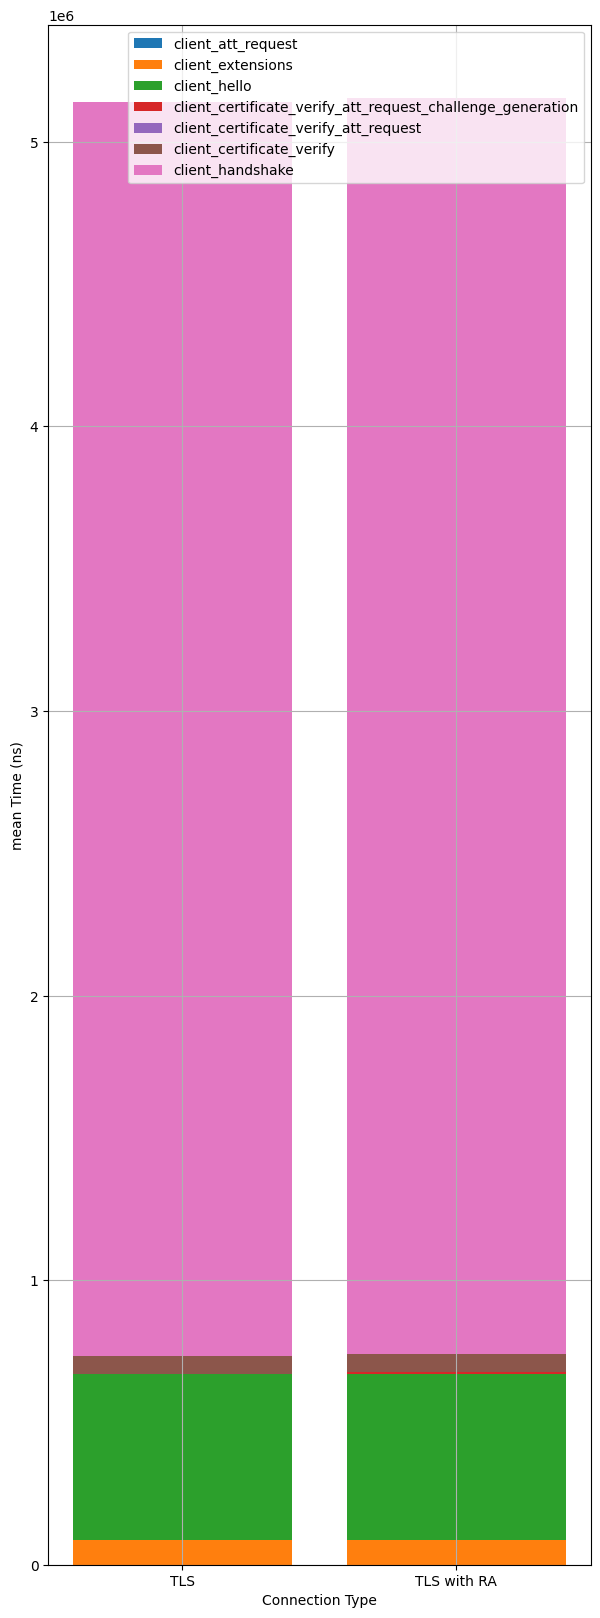

In [140]:
plot_client_bar(client_no_ech, "", True)

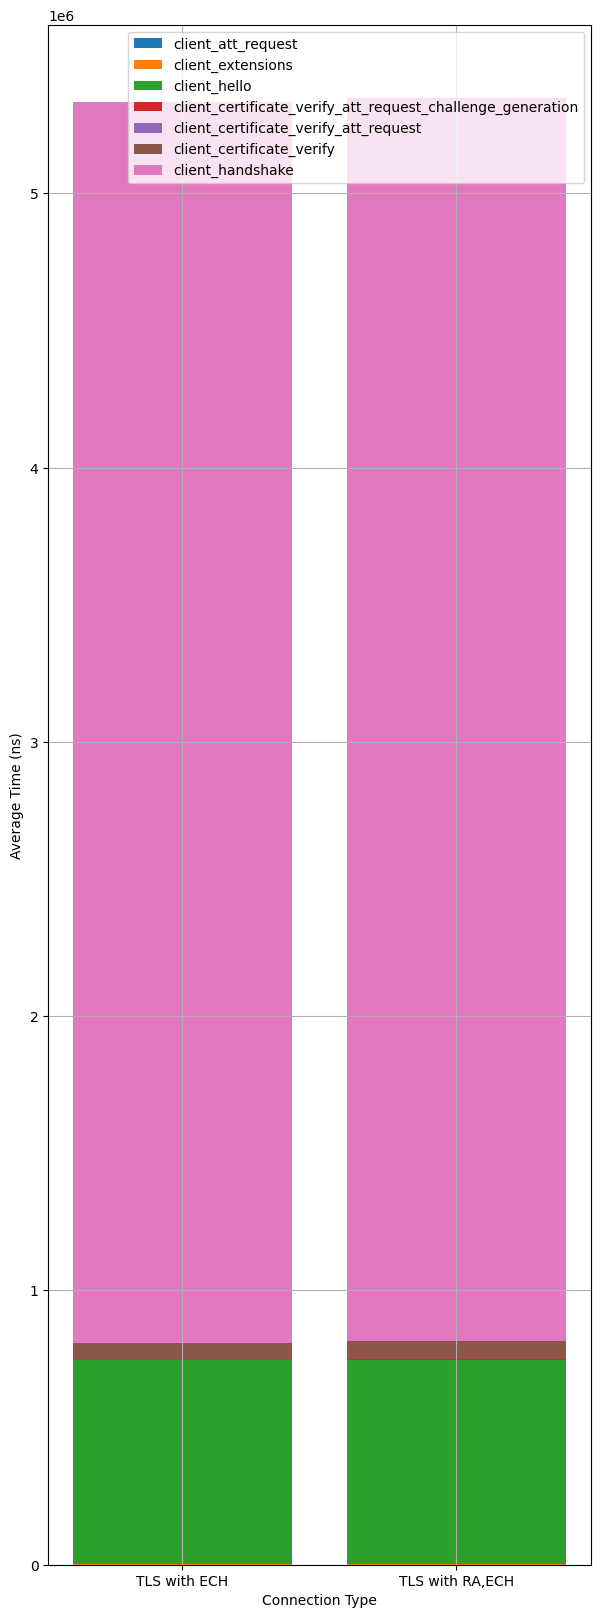

In [141]:
plot_client_bar(client_ech, "", False)

In [142]:
# for key in dataset.CLIENT_KEYS:
#     plot_histogram(client_ech, key, f"{key} - with ECH")
# for key in dataset.SERVER_KEYS:
#     plot_histogram(server_ech, key, f"{key} - with ECH")

In [143]:
hs_diff = client_tls_ra.mean["client_handshake"] - client_tls.mean["client_handshake"]
print("Δ Handshake (ns):           ", hs_diff)

ce_diff = client_tls_ra.mean["client_extensions"] - client_tls.mean["client_extensions"]
print("Δ ClientExtensions (ns):    ", ce_diff)
cv_diff = client_tls_ra.mean["client_certificate_verify"] - client_tls.mean["client_certificate_verify"]
print("Δ Certificate Verify (ns):  ", cv_diff)
se_diff = server_tls_ra.mean["server_extensions"] - server_tls.mean["server_extensions"]
print("Δ EncryptedExtensions (ns): ", se_diff)

sum = ce_diff + cv_diff + se_diff
print("Δ Sum (ns):                 ", sum)

diff = hs_diff - sum
print("Δ (ns):       ", diff)

Δ Handshake (ns):            14728.61371578928
Δ ClientExtensions (ns):     -381.05283157894155
Δ Certificate Verify (ns):   5237.189726315795
Δ EncryptedExtensions (ns):  7687.884800000003
Δ Sum (ns):                  12544.021694736857
Δ (ns):        2184.5920210524237


In [145]:
# AttReq Encoding
plot_histogram(client_no_ech, "client_att_request", time_unit="ns")